In [ ]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt

# ANNs for Regression

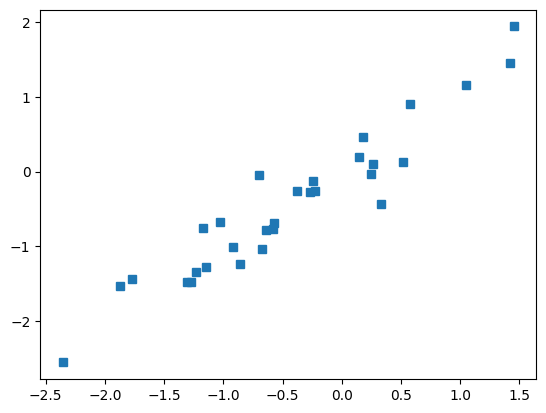

In [ ]:
n = 30

x = torch.randn(n, 1)
y = x + torch.randn(n, 1) / 3

plt.plot(x, y, 's')

In [ ]:
ANN_reg = nn.Sequential(
    nn.Linear(1, 1), # input layer
    nn.ReLU(), # activation layer
    nn.Linear(1, 1) # output layer
)
ANN_reg

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
learning_rate = 0.05
loss_function = nn.MSELoss()

# Gradient Descent
gradient_descent = torch.optim.SGD(ANN_reg.parameters(), lr=learning_rate)

In [ ]:
epoches_num = 400

losses = torch.zeros(epoches_num)

for i in range(epoches_num):
  y_hat = ANN_reg(x)

  loss = loss_function(y_hat, y)
  losses[i] = loss

  gradient_descent.zero_grad()
  loss.backward()
  gradient_descent.step()


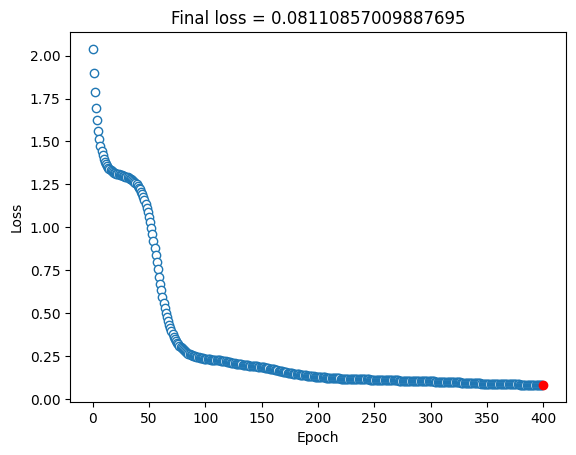

In [ ]:
y_hat = ANN_reg(x)

final_loss = loss_function(y_hat, y)

plt.plot(losses.detach(), 'o', markerfacecolor='w')
plt.plot(epoches_num, final_loss.detach(), 'ro')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Final loss = {final_loss.item()}')
plt.show()

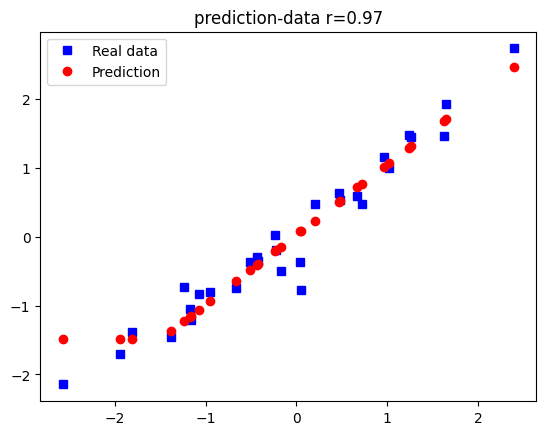

In [ ]:
plt.plot(x, y, 'bs', label="Real data")
plt.plot(x, y_hat.detach(), 'ro', label="Prediction")
plt.title(f'prediction-data r={np.corrcoef(y.T,y_hat.detach().T)[0,1]:.2f}')
plt.legend()

# Classifying Problem

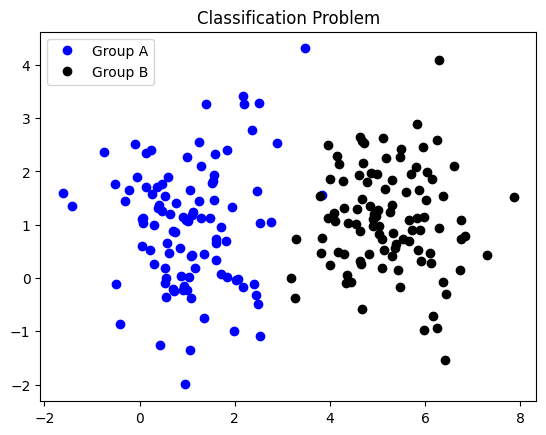

In [ ]:
n_per_clust = 100
standard_dev = 1

# Defining Centers for Clusters
A = [1, 1]
B = [5, 1]

# Generate data

# a and b represent the coordinates of the data points in each cluster
a = [A[0] + np.random.randn(n_per_clust)*standard_dev, A[1] + np.random.randn(n_per_clust) * standard_dev]
b = [B[0] + np.random.randn(n_per_clust)*standard_dev, B[1] + np.random.randn(n_per_clust) * standard_dev]

labels_np = np.vstack((np.zeros((n_per_clust, 1)), np.ones((n_per_clust, 1))))
data_np = np.hstack((a, b)).T

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], 'bo', label='Group A')
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], 'ko', label='Group B')
plt.title("Classification Problem")
plt.legend()


In [ ]:
def create_model(learning_rate):
  classify_model = nn.Sequential(
      nn.Linear(2,1),
      nn.ReLU(),
      nn.Linear(1, 1),
      #nn.Sigmoid(),    # final activation unit (not needed becauese we are gonna use BCEWithLogitsLoss as recommended by pytorch community)
  )
  loss_function = nn.BCEWithLogitsLoss() # it implements the sigmoid function implicitly within it
  optimizer = torch.optim.SGD(classify_model.parameters(), lr = learning_rate)
  return classify_model, loss_function, optimizer

In [ ]:
def train_model(Ann_model, num_epoches, data, labels, optimizer, loss_function):
  losses = torch.zeros(num_epoches)
  for i in range(num_epoches):
    # forward pass
    y_hat = Ann_model(data)

    # loss calculation
    loss = loss_function(y_hat, labels)
    losses[i] = loss

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  prediction = Ann_model(data)

  # Calculate the accuracy of the model as a percentage.
  # 1. `predictions > 0`:
  #    - Since we are using `BCEWithLogitsLoss`, the model outputs raw logits (i.e., unnormalized scores).
  #    - The logits are not passed through a sigmoid activation function, so the raw score itself is compared to 0 as the threshold for classification.
  #    - A value greater than 0 corresponds to a predicted class of 1 (positive class), and a value less than or equal to 0 corresponds to a predicted class of 0 (negative class).
  #    - If we were using `BCELoss` (binary cross-entropy loss) with sigmoid activation, we'd typically threshold the output at 0.5, but this isn't necessary when using `BCEWithLogitsLoss`.
  # 2. `(predictions > 0) == labels`:
  #    - Compares the predicted classes (based on the threshold of 0) to the true labels.
  #    - This will be `True` (1.0) if the prediction matches the label, and `False` (0.0) otherwise.
  # 3. `.float()`:
  #    - Converts the boolean tensor to float values, where `True` becomes 1.0 and `False` becomes 0.0.
  # 4. `torch.mean(...)`:
  #    - Computes the mean of the float tensor, which represents the fraction of correct predictions (accuracy as a value between 0 and 1).
  # 5. `100 * ...`:
  #    - Scales the accuracy value by 100 to convert it into a percentage.

  accuracy = 100 * torch.mean(((prediction>0) == labels).float())
  return prediction, accuracy, losses

### Test the new code by running it once

Final accuracy: 96.5


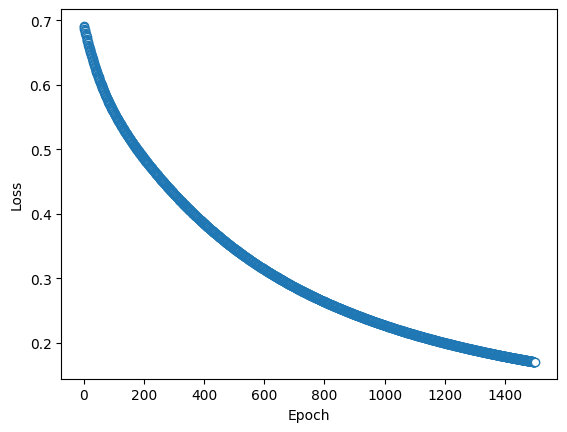

In [ ]:
# create everything
classify_model,loss_fun,optimizer = create_model(.01)

# run it
prediction,acc, losses = train_model(classify_model, num_epoches = 1500, data=data, labels=labels, optimizer=optimizer, loss_function=loss_fun)

# report accuracy
print(f'Final accuracy: {acc}')


# show the losses
plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

## Running Experiment

In [ ]:
learning_rate = np.linspace(0.001, 1, 50)
num_epoches = 1500
# create lists
acc_by_learning_rate = []

# Initialize an array to store the loss values for each learning rate and each epoch.
# The array will have a shape of (num_learning_rates, num_epochs), where:
# - `len(learning_rate)` is the number of different learning rates we are testing.
# - `num_epoches` is the number of epochs for which each model is trained.
# We use `np.zeros` instead of `torch.zeros` because we are storing loss values that
# don't require gradient tracking (they're just for later analysis and comparison).
# NumPy arrays are efficient for general-purpose storage and manipulation, and we don't
# need the features of a PyTorch tensor (like automatic differentiation) for this purpose.
all_losses = np.zeros((len(learning_rate), num_epoches))

for i, lr in enumerate(learning_rate):
  # Create the model
  classify_model, loss_fun, optimizer = create_model(lr)
  # train the model
  prediction, acc, losses = train_model(Ann_model=classify_model, num_epoches=num_epoches, data=data, labels=labels,
                                        optimizer=optimizer, loss_function=loss_fun)
  # store the result
  acc_by_learning_rate.append(acc)
  all_losses[i,:] = losses.detach()



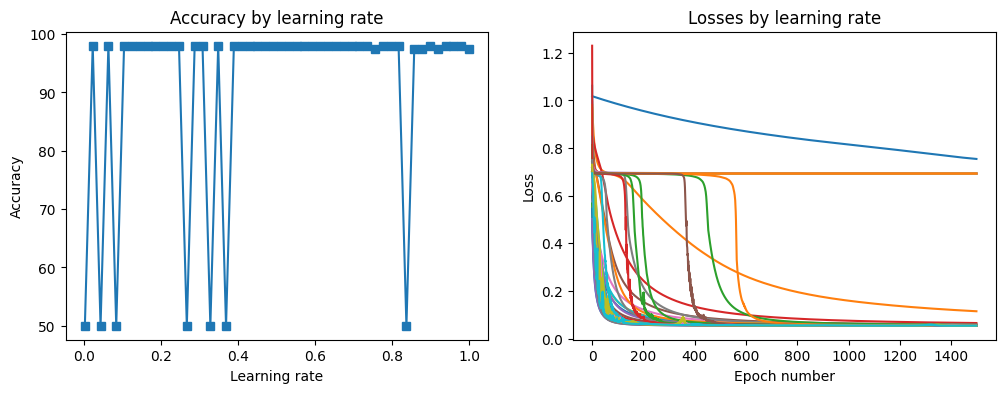

In [ ]:
# plot the results
fig,ax = plt.subplots(1,2, figsize=(12,4)) # The argument (12, 4) represents the width and height of the figure, respectively, in inches.

ax[0].plot(learning_rate,acc_by_learning_rate,'s-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(all_losses.T)
ax[1].set_title('Losses by learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
plt.show()

In [ ]:
# proportion of runs where the model had at least 70% accuracy
sum(np.array(acc_by_learning_rate)>70)/len(acc_by_learning_rate)

0.86

## Run a meta-experiment to get more reliable results

In [ ]:
num_exp = 50
num_epoches = 500 # fewer epochs to reduce computation time
acc_mat = np.zeros((num_exp, len(learning_rate)))
for exp_i in range(num_exp):
  for lr_i, lr in enumerate(learning_rate):
    # create model
    classify_model, loss_fun ,optimizer = create_model(lr)
    # train model
    prediction, acc, losses = train_model(Ann_model=classify_model, num_epoches=num_epoches, data=data, labels=labels,
                                        optimizer=optimizer, loss_function=loss_fun)
    # store results
    acc_mat[exp_i, lr_i] = acc

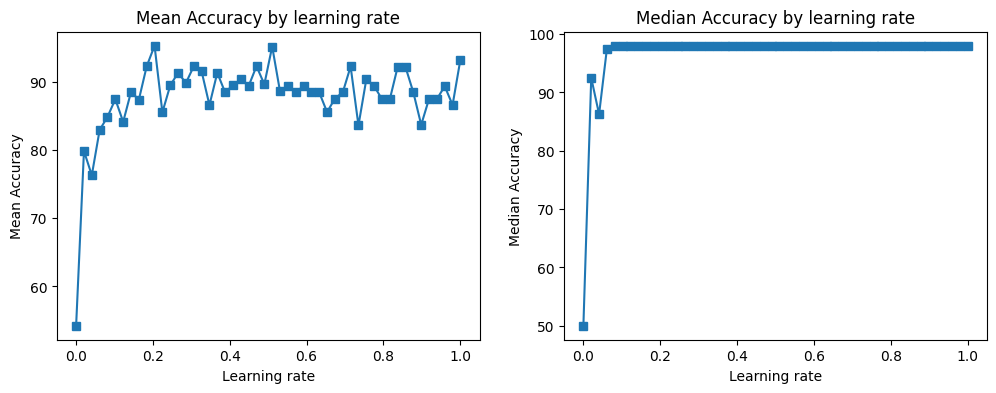

In [ ]:
# now plot the results, averaged over experiments
fig,ax = plt.subplots(1,2, figsize=(12,4))
ax[0].set_title('Mean Accuracy by learning rate')
ax[0].plot(learning_rate,np.mean(acc_mat,axis=0),'s-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Mean Accuracy')

ax[1].set_title('Median Accuracy by learning rate')
ax[1].plot(learning_rate,np.median(acc_mat,axis=0) ,'s-')
ax[1].set_xlabel('Learning rate')
ax[1].set_ylabel('Median Accuracy')


plt.show()

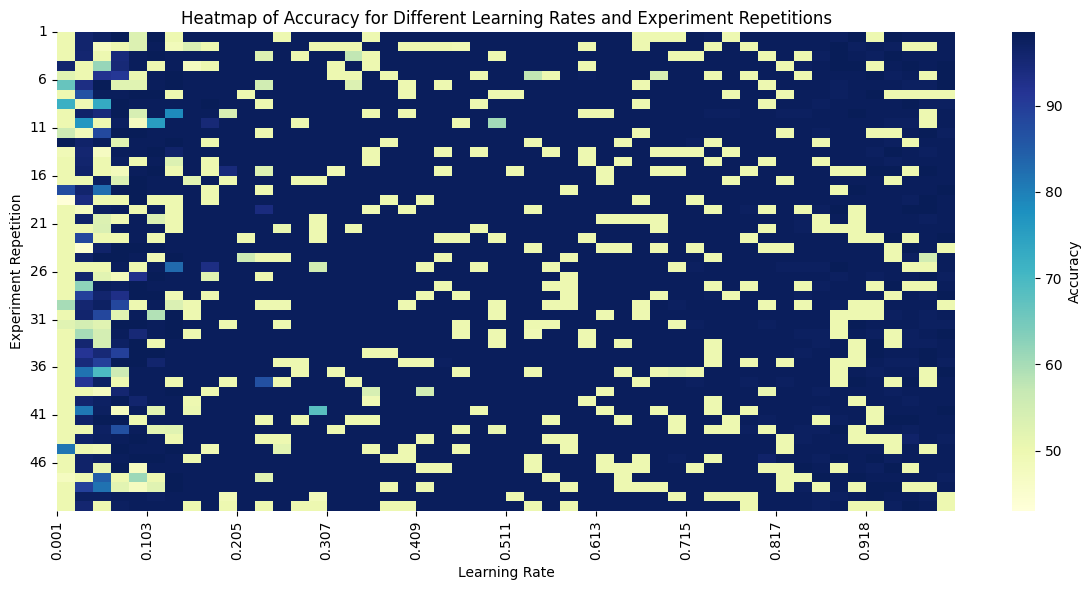

In [ ]:
import seaborn as sns

# Step 1: Get the minimum and maximum accuracies for color scaling
vmin = np.min(acc_mat)  # Minimum accuracy in the dataset
vmax = np.max(acc_mat)

# Step 2: Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(acc_mat, cmap='YlGnBu', xticklabels=learning_rate,
            yticklabels=range(1, num_exp+1), cbar_kws={'label': 'Accuracy'},
            vmin=vmin, vmax=vmax)

# Step 3: Label the axes and add a title
plt.xlabel('Learning Rate')
plt.ylabel('Experiment Repetition')
plt.title('Heatmap of Accuracy for Different Learning Rates and Experiment Repetitions')

# Step 4: Adjusting X-ticks and Y-ticks to show only a subset of them

x_ticks_to_show = np.arange(0, len(learning_rate), 5)  # Every 5th tick
plt.xticks(ticks=x_ticks_to_show, labels=[f'{lr:.3f}' for lr in np.array(learning_rate)[x_ticks_to_show]])

y_ticks_to_show = np.arange(0, num_exp, 5)  # Every 5th experiment repetition
plt.yticks(ticks=y_ticks_to_show, labels=[f'{i+1}' for i in y_ticks_to_show])

# Show the plot
plt.tight_layout()
plt.show()

## Trying Multi-layer Model

In [ ]:
def create_multi_layer_model(learning_rate):
  Ann_model = nn.Sequential(
      nn.Linear(2, 16),
      nn.ReLU(),
      nn.Linear(16,1),
      nn.ReLU(),
      nn.Linear(1, 1)
  )
  loss_function = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(Ann_model.parameters(), lr=learning_rate)
  return Ann_model, loss_function, optimizer

### Re-running Experiment

In [ ]:
learning_rate = np.linspace(0.001, 1, 50)
acc_multi_by_lr = []
num_epoches = 1500

for lr_i, lr in enumerate(learning_rate):
  # create model
  classify_model, loss_fun, optimizer = create_multi_layer_model(lr)
  # train model
  prediction, acc, losses = train_model(Ann_model=classify_model, num_epoches=num_epoches, data=data,
                                        labels=labels, optimizer=optimizer, loss_function=loss_fun)
  # store result
  acc_multi_by_lr.append(acc)

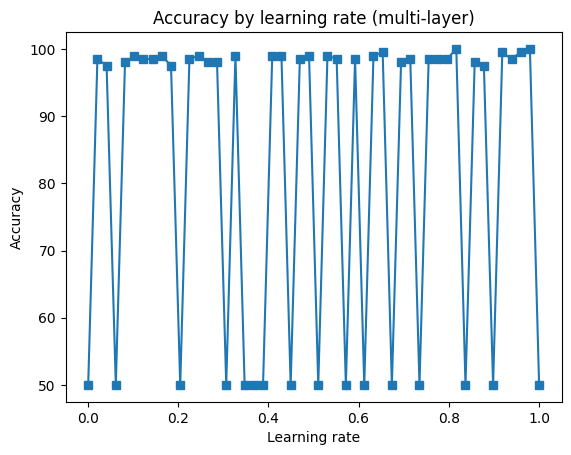

In [ ]:
plt.plot(learning_rate,acc_multi_by_lr,'s-')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Accuracy by learning rate (multi-layer)')
plt.show()

# Fixing The Incosistincy Problem By Using Linear Solution

In [ ]:
def create_linear_model(learning_rate):
  Ann_model = nn.Sequential(
      nn.Linear(2, 1)
  )
  loss_function = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(Ann_model.parameters(), lr=learning_rate)
  return Ann_model, loss_function, optimizer

In [ ]:
learning_rate = np.linspace(0.001, 1, 50)
acc_linear_by_lr = []
num_epoches = 1000

for lr_i, lr in enumerate(learning_rate):
  # create model
  classify_model, loss_fun, optimizer = create_linear_model(lr)
  # train model
  prediction, acc, losses = train_model(Ann_model=classify_model, num_epoches=num_epoches, data=data,
                                        labels=labels, optimizer=optimizer, loss_function=loss_fun)
  # store result
  acc_linear_by_lr.append(acc)

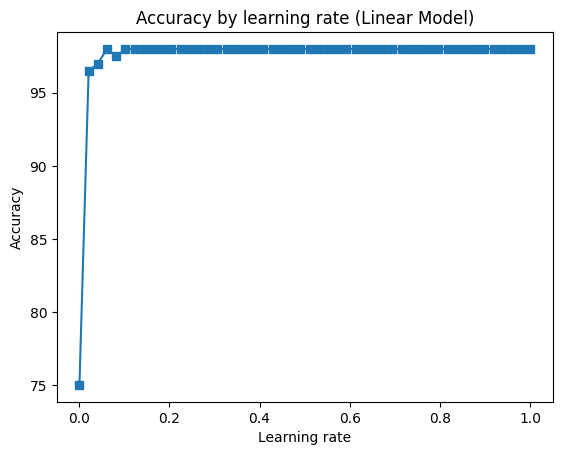

In [ ]:
plt.plot(learning_rate,acc_linear_by_lr,'s-')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Accuracy by learning rate (Linear Model)')
plt.show()

# Multi-output ANN (iris dataset)

In [ ]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


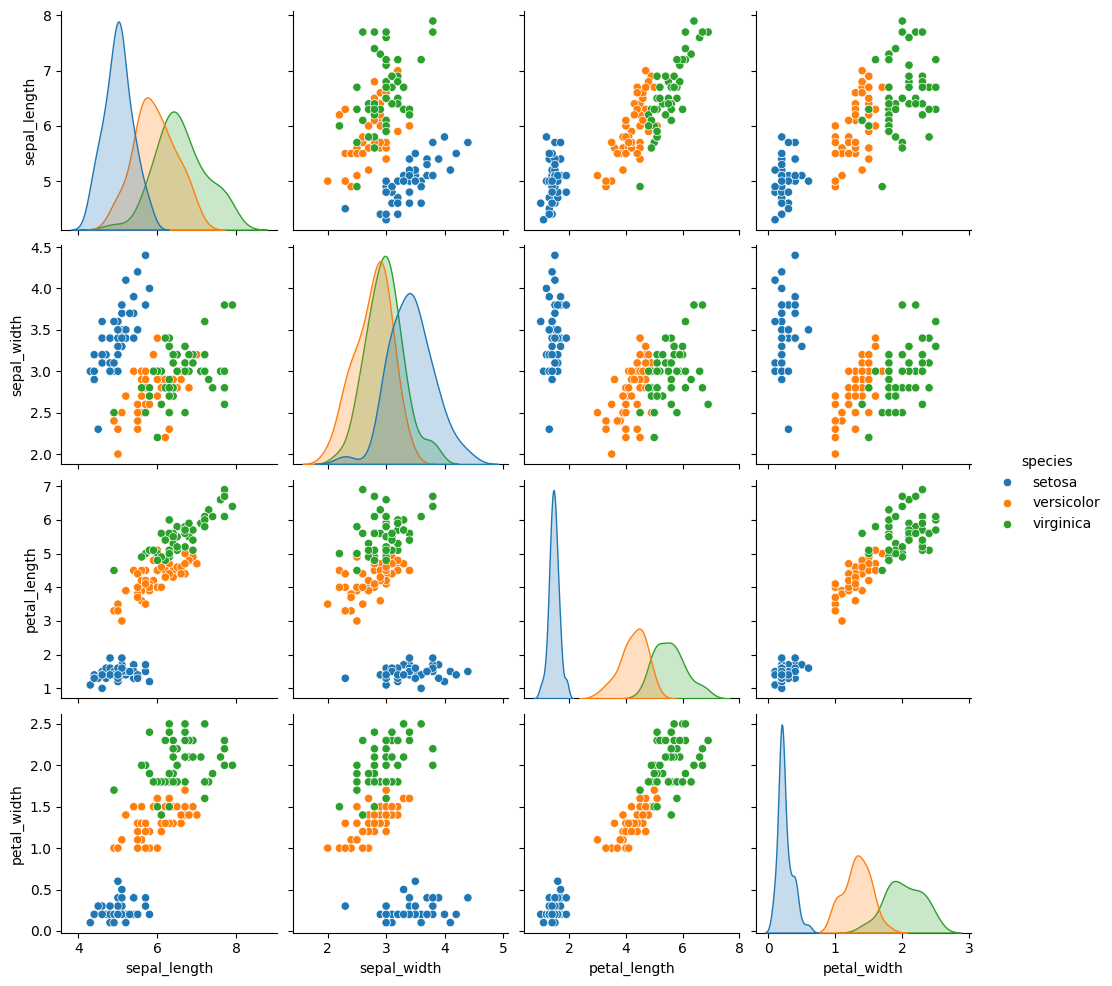

In [ ]:
sns.pairplot(iris, hue='species')
plt.show()

In [ ]:
data_iris = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels_iris = torch.zeros(len(data_iris), dtype=torch.long)
labels_iris[iris.species=='versicolor'] = 1
labels_iris[iris.species=='virginica'] = 2


## Create the ANN model

In [ ]:
Ann_iris = nn.Sequential(
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64, 3)
)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(Ann_iris.parameters(), lr=0.1)

## Train the model

In [ ]:
num_epoches = 1500

losses = torch.zeros(num_epoches)
acc_epoches = []

for epoch_i in range(num_epoches):
  # forward pass
  y_hat = Ann_iris(data_iris)

  # compute loss
  loss = loss_function(y_hat, labels_iris)
  losses[epoch_i] = loss

  # back prop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # compute accuracy
  matches = (torch.argmax(y_hat, axis=1) == labels_iris).float()
  acc = 100*torch.mean(matches)
  acc_epoches.append(acc)

predictions = Ann_iris(data_iris)
prediction_category = torch.argmax(predictions, axis=1)
sm = nn.Softmax(dim=1)
probabilities = sm(predictions)

final_acc = 100* torch.mean(( prediction_category == labels_iris).float())

Final accuracy: 98.66667175292969


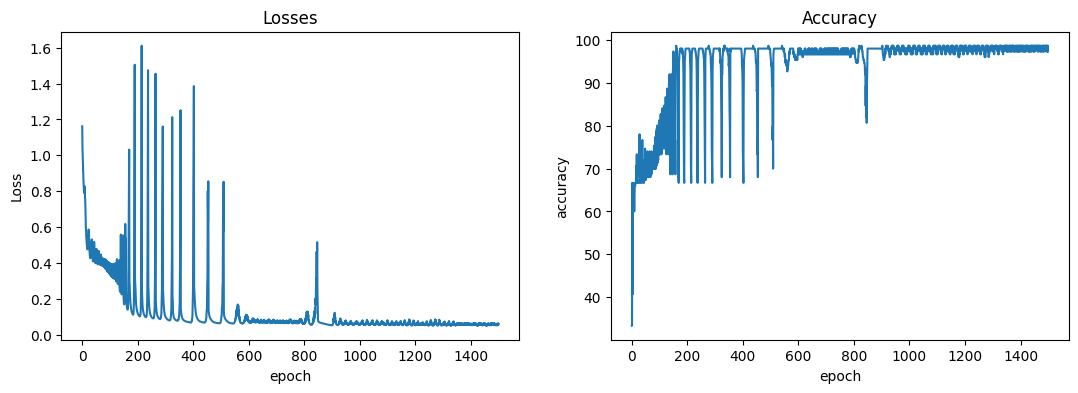

In [ ]:
# report accuracy
print(f'Final accuracy: {final_acc}')

fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(acc_epoches)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy')
plt.show()

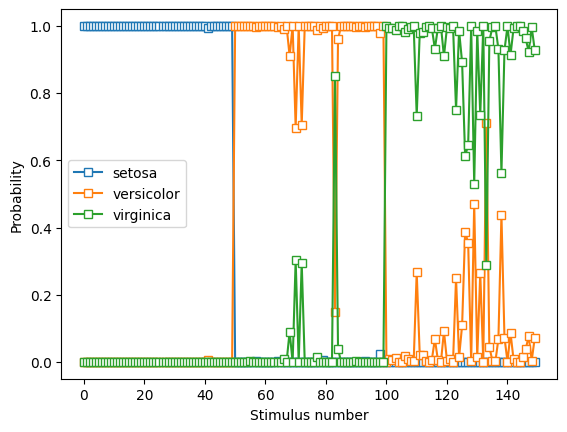

In [ ]:
plt.plot(probabilities.detach().numpy(),'s-',markerfacecolor='w')
plt.xlabel('Stimulus number')
plt.ylabel('Probability')
plt.legend(['setosa','versicolor','virginica'])
plt.show()

# Comparing The Number Of Hidden Units

In [ ]:
def create_nHidden_model(nHidden):
  model = nn.Sequential(
      nn.Linear(4, nHidden),
      nn.ReLU(),
      nn.Linear(nHidden, nHidden),
      nn.ReLU(),
      nn.Linear(nHidden, 3)
  )
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
  return model, loss_function, optimizer

In [ ]:
nHidden = numhiddens = np.arange(1,129)
epoches_num = 500
def train_nHidden(n_units):
  # initialze the model
  ann_model, loss_function, optimizer = create_nHidden_model(n_units)
  for i in range(epoches_num):
    # forward pass
    y_hat = ann_model(data_iris)

    # compute loss
    loss = loss_function(y_hat, labels_iris)

    # backward prop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  prediction = ann_model(data_iris)
  acc = 100 * torch.mean((torch.argmax(prediction,axis=1)==labels_iris).float())
  return acc

In [ ]:
acc_array = np.zeros(len(nHidden))
for i, n_unit in enumerate(nHidden):
  acc_array[i] = train_nHidden(n_unit)


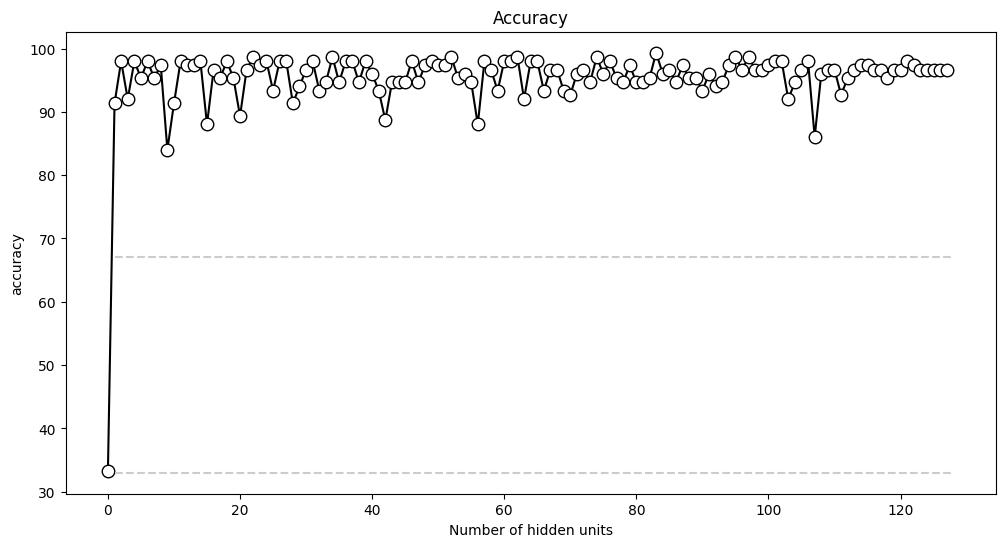

In [ ]:
fig,ax = plt.subplots(1,figsize=(12,6))

ax.plot(acc_array,'ko-',markerfacecolor='w',markersize=9)
ax.plot(nHidden[[0,-1]],[33,33],'--',color=[.8,.8,.8])
ax.plot(nHidden[[0,-1]],[67,67],'--',color=[.8,.8,.8])
ax.set_ylabel('accuracy')
ax.set_xlabel('Number of hidden units')
ax.set_title('Accuracy')
plt.show()

# Defining Models Using Sequential vs Customized Class

In [ ]:
import torch.nn.functional as F
class CustomAnnClass(nn.Module):
  def __init__(self):
    super().__init__()
    #input layer
    self.input = nn.Linear(2,1)
    #output layer
    self.output = nn.Linear(1, 1)
  def forward(self, x):
    # input layer
    x = self.input(x)

    # apply relu
    # x = F.relu(x) using a linear model to solve this one as we saw earlier

    # output layer
    x = self.output(x)
    return x

ann_custom_model = CustomAnnClass()
learning_rate = 0.01
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(ann_custom_model.parameters(), lr=learning_rate)


In [ ]:
epoches_num = 1500
losses = torch.zeros(epoches_num)

for i in range(epoches_num):
  # forward pass
  y_hat = ann_custom_model(data)
  # loss function
  loss = loss_function(y_hat, labels)
  losses[i] = loss
  # backward prop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


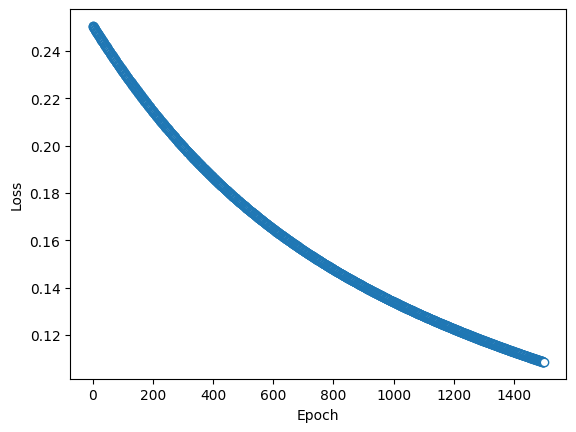

In [ ]:
plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Final accuracy: 99%


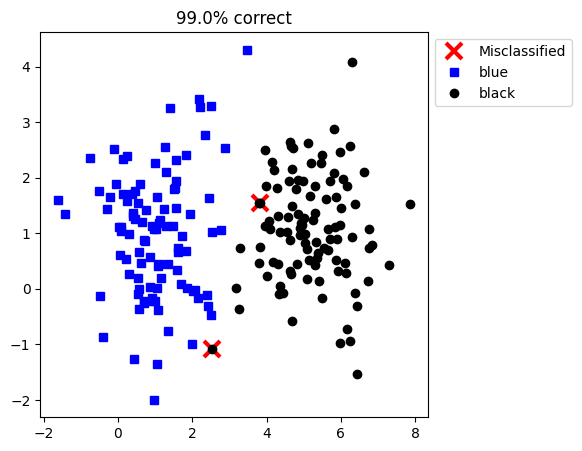

In [ ]:
# final forward pass
predictions = ann_custom_model(data)

predlabels = predictions>0.5

# find errors
misclassified = np.where(predlabels != labels)[0]

# total accuracy
totalacc = 100-100*len(misclassified)/(2*n_per_clust)

print(f'Final accuracy: {totalacc}')
fig = plt.figure(figsize=(5,5))
plt.plot(data[misclassified,0] ,data[misclassified,1],'rx',markersize=12,markeredgewidth=3)
plt.plot(data[np.where(~predlabels)[0],0],data[np.where(~predlabels)[0],1],'bs')
plt.plot(data[np.where(predlabels)[0],0] ,data[np.where(predlabels)[0],1] ,'ko')

plt.legend(['Misclassified','blue','black'],bbox_to_anchor=(1,1))
plt.title(f'{totalacc}% correct')
plt.show()

# Model depth vs. breadth

## Number Of Parameters

In [ ]:
# build two models

breadth_net = nn.Sequential(
    nn.Linear(2,4),  # hidden layer
    nn.Linear(4,3),  # output layer
    )


deep_net = nn.Sequential(
    nn.Linear(2,2),  # hidden layer
    nn.Linear(2,2),  # hidden layer
    nn.Linear(2,3),  # output layer
    )

# print them out to have a look
print(breadth_net)
print(' ')
print(deep_net)

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=3, bias=True)
)
 
Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
  (2): Linear(in_features=2, out_features=3, bias=True)
)


## Peeking Inside the Network

In [ ]:
for p in deep_net.named_parameters():
  print(p)
  print(' ')

('0.weight', Parameter containing:
tensor([[-0.1181,  0.5004],
        [-0.1645, -0.0164]], requires_grad=True))
 
('0.bias', Parameter containing:
tensor([-0.5959, -0.1894], requires_grad=True))
 
('1.weight', Parameter containing:
tensor([[ 0.5707, -0.0924],
        [-0.2231, -0.4962]], requires_grad=True))
 
('1.bias', Parameter containing:
tensor([-0.5422, -0.5008], requires_grad=True))
 
('2.weight', Parameter containing:
tensor([[ 0.6784, -0.6120],
        [-0.4472,  0.5889],
        [ 0.5500,  0.1675]], requires_grad=True))
 
('2.bias', Parameter containing:
tensor([-0.3750,  0.3331, -0.2189], requires_grad=True))
 


In [ ]:
# count the number of nodes ( = the number of biases)

# named_parameters() is an iterable that returns the tuple (name,numbers)
numNodesInWide = 0
for p in breadth_net.named_parameters():
  if 'bias' in p[0]:
    numNodesInWide += len(p[1])

numNodesInDeep = 0
for paramName,paramVect in deep_net.named_parameters():
  if 'bias' in paramName:
    numNodesInDeep += len(paramVect)


print(f'There are {numNodesInWide} nodes in the wide network.')
print(f'There are {numNodesInDeep} nodes in the deep network.')

There are 7 nodes in the wide network.
There are 7 nodes in the deep network.


In [ ]:
# just the parameters
for p in breadth_net.parameters():
  print(p)
  print(' ')


Parameter containing:
tensor([[ 0.6233,  0.5269],
        [-0.6869,  0.0599],
        [ 0.3007, -0.0341],
        [-0.3101,  0.0128]], requires_grad=True)
 
Parameter containing:
tensor([ 0.2801,  0.1515,  0.2714, -0.3412], requires_grad=True)
 
Parameter containing:
tensor([[-0.3561,  0.3559,  0.3514,  0.3486],
        [-0.2962,  0.4641, -0.2525, -0.1450],
        [ 0.4322,  0.0786,  0.0210,  0.0558]], requires_grad=True)
 
Parameter containing:
tensor([-0.1787, -0.3234,  0.0754], requires_grad=True)
 


In [ ]:
# now count the total number of trainable parameters
print("Breadth network has: ")
nparams = 0
for p in breadth_net.parameters():
  if p.requires_grad:
    print(f'This piece has {p.numel()} parameters')
    nparams += p.numel()

print(f'\n\nTotal of {nparams} parameters')


Breadth network has: 
This piece has 8 parameters
This piece has 4 parameters
This piece has 12 parameters
This piece has 3 parameters


Total of 27 parameters


### A nice way to print a summary of the network

In [ ]:
from torchsummary import summary
summary(breadth_net,(1,2))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 4]              12
            Linear-2                 [-1, 1, 3]              15
Total params: 27
Trainable params: 27
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Model depth vs. breadth Experiment

In [ ]:
class AnnIris(nn.Module):
  def __init__(self, nUnits, nLayers):
    super().__init__()
    self.layers = nn.ModuleDict()
    self.nLayers = nLayers

    self.layers['input'] = nn.Linear(4, nUnits)

    for i in range(nLayers):
      self.layers[f'hidden{i}'] = nn.Linear(nUnits, nUnits)

    self.layers['output'] = nn.Linear(nUnits, 3)

  def forward(self, x):
    x = F.relu( self.layers['input'](x) )
    # hidden layers
    for i in range(self.nLayers):
      x = F.relu( self.layers[f'hidden{i}'](x) )
    # return output layer
    x = self.layers['output'](x)
    return x

# trial
nUnits = 12
nLayers = 4
model_custom_iris = AnnIris(nUnits,nLayers)
print(model_custom_iris)

AnnIris(
  (layers): ModuleDict(
    (input): Linear(in_features=4, out_features=12, bias=True)
    (hidden0): Linear(in_features=12, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)


In [ ]:
# 10 samples, 4 dimensions
tmpx = torch.randn(10,4)

# run it through the DL
y_test = model_custom_iris(tmpx)

# exam the shape of the output
print( y_test.shape )

torch.Size([10, 3])


In [ ]:
def train_Custom_Iris(theModel):

  # define the loss function and optimizer
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(theModel.parameters(),lr=0.01)
  epoches_num = 700

  # loop over epochs
  for epochi in range(epoches_num):

    # forward pass
    y_hat = theModel(data_iris)

    # compute loss
    loss = lossfun(y_hat,labels_iris)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



  # final forward pass to get accuracy
  predictions = theModel(data_iris)
  predlabels = torch.argmax(predictions,axis=1)
  acc = 100*torch.mean((predlabels == labels_iris).float())

  # total number of trainable parameters in the model
  nParams = 0
  for p in theModel.parameters():
    if p.requires_grad:
      nParams += 1

  # function outputs
  return acc, nParams

In [ ]:
# test the function once
acc, nParams = train_Custom_Iris(model_custom_iris)
print(acc)

tensor(66.6667)


In [ ]:
# define the model parameters
num_layers = range(1,6)         # number of hidden layers
num_units  = np.arange(4,101,3) # units per hidden layer

# initialize output matrices
accuracies  = np.zeros((len(num_units),len(num_layers)))
total_params = np.zeros((len(num_units),len(num_layers)))

# start the experiment!
for unit_idx in range(len(num_units)):
  for layer_idx in range(len(num_layers)):

    # create a fresh model instance
    net = AnnIris(num_units[unit_idx],num_layers[layer_idx])

    # run the model and store the results
    acc,nParams = train_Custom_Iris(net)
    accuracies[unit_idx, layer_idx] = acc

    # store the total number of parameters in the model
    total_params[unit_idx,layer_idx] = nParams

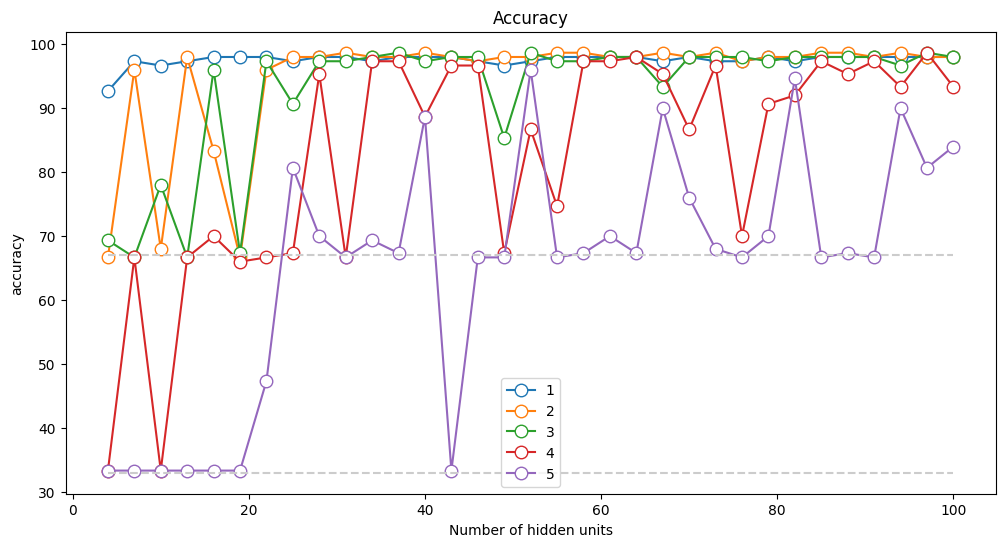

In [ ]:
# show accuracy as a function of model depth
fig,ax = plt.subplots(1,figsize=(12,6))

ax.plot(num_units,accuracies,'o-',markerfacecolor='w',markersize=9)
ax.plot(num_units[[0,-1]],[33,33],'--',color=[.8,.8,.8])
ax.plot(num_units[[0,-1]],[67,67],'--',color=[.8,.8,.8])
ax.legend(num_layers)
ax.set_ylabel('accuracy')
ax.set_xlabel('Number of hidden units')
ax.set_title('Accuracy')
plt.show()

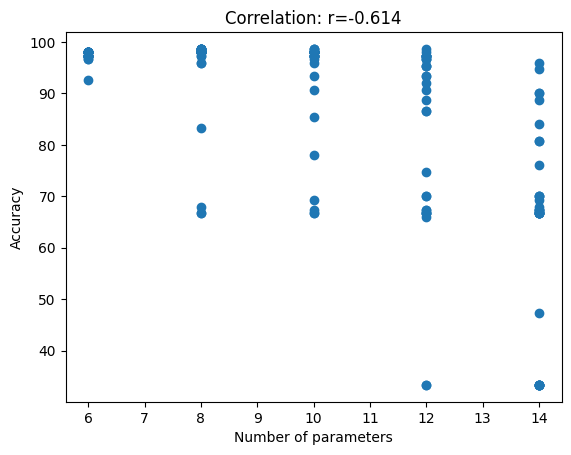

In [ ]:
# vectorize for convenience
x = total_params.flatten()
y = accuracies.flatten()

# correlation between them
r = np.corrcoef(x,y)[0,1]

# scatter plot
plt.plot(x,y,'o')
plt.xlabel('Number of parameters')
plt.ylabel('Accuracy')
plt.title('Correlation: r=' + str(np.round(r,3)))
plt.show()